# Towing Data

Minneapolis snow emergencies are declared on a given day by 6pm following heavy snowfall.  The first day of the snow emergency begins at 9pm the day of the snow emergency declaration.  Day 1 runs overnight from 9pm to 8am. Day 2 runs from 8 am to 8 pm the day after the snow emergency declaration.  Day 3 runs from 8 am to 8 pm two days after the snow emergency declaration.

We consider the file `finalTOWING.csv` to expand the dataset to include information regarding snowfall amounts with the storm. To do this we download NOAA weather data on snowfall for weather stations in/near Hennepin county. 

For each incident of towing, we look up the date that the car was towed `date_towed` and `date_declared`, date that the snow emergency was declared.  We then find the closest weather station based on the towing latitude, longitude coordinates and return the snowfall amounts over the time frame `date_declared - one day` to `date_towed`.

The NOAA data for the snowfalls has varying number of weather stations reporting, so we need to do some ETL work to get that data into a useful format.  

In [40]:
import numpy as np
import pandas as pd
import datetime
from dateutil.parser import parse

In [41]:
tows_df = pd.read_csv("finalTOWING.csv")

In [42]:
tows_df.describe()

ward      latitude     longitude  other_x  other_y  \
count  14248.000000  17184.000000  17184.000000      0.0      0.0   
mean       5.649144     44.975432    -93.267495      NaN      NaN   
std        3.018218      0.027149      0.024902      NaN      NaN   
min        1.000000     44.891776    -93.460853      NaN      NaN   
25%        3.000000     44.953568    -93.289260      NaN      NaN   
50%        5.000000     44.983097    -93.267627      NaN      NaN   
75%        8.000000     44.993131    -93.246718      NaN      NaN   
max       13.000000     45.051151    -93.202271      NaN      NaN   

                day      tow_zone  
count  17184.000000  14248.000000  
mean       2.068319      3.263335  
std        0.742135      1.644727  
min        1.000000      1.000000  
25%        2.000000      2.000000  
50%        2.000000      3.000000  
75%        3.000000      4.000000  
max        3.000000      6.000000

In [43]:
tows_df.columns

Index(['emergency', 'date', 'address', 'ward', 'neighborhood', 'community',
       'latitude', 'longitude', 'other_x', 'other_y', 'day', 'tow_zone'],
      dtype='object')

In [44]:
# Adjust the dates to be datetime.datetime objects 
# - this allows for proper sorting and arithmetic using datetime.timedelta()
# 
import datetime
from dateutil.parser import parse

def convert_dates(dates):
    def try_to_parse_date (a_string):
        try:
            parsed = parse(a_string, fuzzy_with_tokens=True)
        except ValueError:
            print(f"Could not parse a date from `{a_string}`")
        else:
            return parsed[0]
        
    def converter(date):
        if isinstance(date, datetime.datetime):
            return date
        else:
            return try_to_parse_date(date)
    
    return [converter(date) for date in dates]

tows_df.insert(2, 'date_towed', convert_dates(tows_df.date))
#converted_dates

In [54]:
# Determine the date the snow emergency was declared.  This will be the smallest value of date_towed for any day 1 towing.

declaration_dict = tows_df[tows_df.day == 1].groupby('emergency')['date_towed'].min().to_dict()
declaration_dict
    

{'Armatage': Timestamp('2019-02-24 00:00:00'),
 'Dana': Timestamp('2016-12-11 00:00:00'),
 'Diamond Lake': Timestamp('2019-03-10 00:00:00'),
 'Ferry': Timestamp('2016-12-17 00:00:00'),
 'Grant': Timestamp('2015-12-29 00:00:00'),
 'Howe': Timestamp('2018-04-15 00:00:00'),
 'Jane': Timestamp('2017-01-11 00:00:00'),
 'Olive': Timestamp('2018-01-15 00:00:00'),
 'Pembina': Timestamp('2018-01-22 00:00:00'),
 'Polk': Timestamp('2016-02-02 00:00:00'),
 'Quincy': Timestamp('2019-01-28 00:00:00'),
 'Upton': Timestamp('2019-02-07 00:00:00'),
 'Westminster': Timestamp('2019-02-12 00:00:00'),
 'Xerxes': Timestamp('2018-02-23 00:00:00'),
 'Yale': Timestamp('2019-02-20 00:00:00'),
 'Yardville': Timestamp('2018-02-25 00:00:00')}

In [56]:
tows_df.insert(1, 'date_declared', tows_df['emergency'].map(declaration_dict))
tows_df.head()

emergency date_declared     date date_towed  \
0  Armatage    2019-02-24  2/24/19 2019-02-24   
1  Armatage    2019-02-24  2/24/19 2019-02-24   
2  Armatage    2019-02-24  2/24/19 2019-02-24   
3  Armatage    2019-02-24  2/24/19 2019-02-24   
4  Armatage    2019-02-24  2/24/19 2019-02-24   

                                    address  ward     neighborhood  \
0        2101 LYNDALE AVE N ,Minneapolis,MN   5.0        Hawthorne   
1        2101 LYNDALE AVE N ,Minneapolis,MN   5.0        Hawthorne   
2         2806 EMERSON AVE S,Minneapolis,MN  10.0  Lowry Hill East   
3        2901 Lyndale Ave n ,Minneapolis,MN   5.0        Hawthorne   
4  2800 Emerson Avenue South,Minneapolis,MN  10.0  Lowry Hill East   

      community   latitude  longitude  other_x  other_y  day  tow_zone  
0    Near North  45.000250 -93.287993      NaN      NaN    1       1.0  
1    Near North  45.000250 -93.287993      NaN      NaN    1       1.0  
2  Calhoun Isle  44.951599 -93.294638      NaN      NaN    1       3.0  
3    Near North  45.009708 -93.288395      NaN      NaN    1       1.0  
4  Calhoun Isle  44.951578 -93.294725      NaN      NaN    1       3.0

In [61]:
len(sorted(tows_df.date_towed.unique()))

46

In [62]:
# Since we are looking at days prior to the snow emergency declaration and the NOAA weather station data is monthly,
# we need to enlarge the number of dates that are going to be pulled from the NOAA site in case there are monthly cross-overs
# The following function creates this list of enlarged dates.

def enlarge_dates_list(tow_dates):
    # a helper function to push dates into a list.
    def check_date_in_list(date, my_list):
        if date not in my_list:
            my_list.append(date)
            
    enlarged_dates = []
    for date in tow_dates:
        check_date_in_list(date, enlarged_dates)
        check_date_in_list(date - datetime.timedelta(days=1), enlarged_dates)
        check_date_in_list(date - datetime.timedelta(days=2), enlarged_dates)
        check_date_in_list(date - datetime.timedelta(days=3), enlarged_dates)
        
    return enlarged_dates

In [64]:
enlarged_dates = enlarge_dates_list(tows_df.date_towed)

In [65]:
len(enlarged_dates)

88

In [67]:
# make API endpoint names from the above information
# https://www.ncdc.noaa.gov/snow-and-ice/daily-snow/MN-snowfall-201903.json
# Use a set generator to drop duplicates by default

def create_api_endpoints(dates):
    # three helper functions
    def zero_pad_month(month):
        return str(month).zfill(2)
    
    def combine_month_year(months, year):
        month_years = zip(months, years)
        return {str(year) + zero_pad_month(month) for (month, year) in month_years}

    def make_endpoints(endpoint_prefix, endpoint_suffix, changing_term):
        return [endpoint_prefix + term + endpoint_suffix for term in changing_term]

    months = [day.month for day in dates]
    years = [day.year for day in dates]
    unique_month_years = combine_month_year(months, years)
    api_endpoints = (make_endpoints("https://www.ncdc.noaa.gov/snow-and-ice/daily-snow/MN-snowfall-",
                                        ".json",
                                        unique_month_years))
    
    return unique_month_years, api_endpoints

unique_month_years, api_endpoints = create_api_endpoints(enlarged_dates)
sorted(api_endpoints)

['https://www.ncdc.noaa.gov/snow-and-ice/daily-snow/MN-snowfall-201512.json',
 'https://www.ncdc.noaa.gov/snow-and-ice/daily-snow/MN-snowfall-201601.json',
 'https://www.ncdc.noaa.gov/snow-and-ice/daily-snow/MN-snowfall-201602.json',
 'https://www.ncdc.noaa.gov/snow-and-ice/daily-snow/MN-snowfall-201612.json',
 'https://www.ncdc.noaa.gov/snow-and-ice/daily-snow/MN-snowfall-201701.json',
 'https://www.ncdc.noaa.gov/snow-and-ice/daily-snow/MN-snowfall-201801.json',
 'https://www.ncdc.noaa.gov/snow-and-ice/daily-snow/MN-snowfall-201802.json',
 'https://www.ncdc.noaa.gov/snow-and-ice/daily-snow/MN-snowfall-201804.json',
 'https://www.ncdc.noaa.gov/snow-and-ice/daily-snow/MN-snowfall-201901.json',
 'https://www.ncdc.noaa.gov/snow-and-ice/daily-snow/MN-snowfall-201902.json',
 'https://www.ncdc.noaa.gov/snow-and-ice/daily-snow/MN-snowfall-201903.json']

In [68]:
## Now get the snowfall data and build it up as a json

import requests
import json

def get_snowfall_jsons(unique_month_years, api_endpoints):
    
    all_snowfalls = {}
    snowfalls = []
    for (monthyear, endpoint) in zip(unique_month_years, api_endpoints):
        snowfall = {}
        response = requests.get(endpoint)
        print(monthyear, response)
        snowfall["date"] = monthyear
        if response:
            snowfall["data"] = response.json()
        else:
            snowfall["data"] = False
        snowfalls.append(snowfall)
        
    all_snowfalls["snowfalls"] = snowfalls
    return all_snowfalls


In [69]:
snowfalls = get_snowfall_jsons(unique_month_years, api_endpoints)

201701 <Response [200]>
201901 <Response [200]>
201802 <Response [200]>
201612 <Response [200]>
201801 <Response [200]>
201902 <Response [200]>
201601 <Response [200]>
201804 <Response [200]>
201512 <Response [404]>
201903 <Response [200]>
201602 <Response [200]>


In [70]:
# How many unique months of data do we have?  Note that 201512 is unavailable:  Response [404]
print(len(snowfalls), len(snowfalls['snowfalls']))

1 11


In [71]:
## To avoid making API calls again, we can save our data so far:

with open('snowfalls.json', 'w') as outfile:  
    json.dump(snowfalls, outfile)

In [73]:
## Uncomment the lines below to pick up the analysis from here and start again
with open('snowfalls.json', 'r') as infile:
    reloaded_snowfalls = json.load(infile)

In [79]:
# This gets all of the weather stations for the first snowfall:
# snowfalls['snowfalls'][0]['data']['data'].keys()

# How many weather stations per month/year combinations?
# We will see that there are varying number of weather stations available.

def count_weather_stations ():
    station_count = []
    
    for i in range(len(snowfalls['snowfalls'])):
        if snowfalls['snowfalls'][i]['data']:
            station_count.append(len(snowfalls['snowfalls'][i]['data']['data'].keys()))
        else:
            station_count.append(0)
    return station_count

count_weather_stations()

[311, 358, 358, 343, 354, 373, 349, 406, 0, 371, 336]

In [81]:
# Determine the largest set of MN weather stations:

def get_mn_weather_stations(jsobject):
    # Loop over all snowstorms and find all of the unique weather stations
    snowfall_list = jsobject['snowfalls']
    stations = []
    
    for snowfall in snowfall_list:
        # print(snowfall['date'])
        # recall one snowfall has no data available from the server:
        if (snowfall['data']):
            stations.append( list(snowfall['data']['data'].keys()) )
            
    flat_list = [item for sublist in stations for item in sublist]
    
    return list(set(flat_list))

mn_stations = get_mn_weather_stations(snowfalls)
print(len(mn_stations)) # 548 of these
# mn_stations 

548


In [82]:
# Make a data frame of mn weather stations
def make_mn_stations_df (stations, jsobject):
    
    snowfall_list = jsobject['snowfalls']
    
    #new_stations = []
    already_found_stations = []
    lat = []
    lon = []
    county = []
    name = []
    
    for snowfall in snowfall_list:
        
        if (snowfall['data']):
            # see if station is in the snowfall:
            for station in stations:
                if station in snowfall['data']['data'].keys():
                    # get station data
                    if station not in already_found_stations:
                        already_found_stations.append(station)
                        lat.append(float(snowfall['data']['data'][station]['lat']))
                        lon.append(float(snowfall['data']['data'][station]['lon']))
                        county.append(snowfall['data']['data'][station]['county'])
                        name.append(snowfall['data']['data'][station]['station_name'])
    
    # make a dataframe of stations from the lists:
    data_dict = {'Station': already_found_stations,\
                'Name': name,\
                'County': county,\
                'lat': lat, 'lon': lon}
    
    stations_df = pd.DataFrame(data_dict)
    return stations_df


In [84]:
mn_stations_df = make_mn_stations_df(mn_stations, snowfalls)

In [85]:
mn_stations_df.head()

Station                   Name         County    lat    lon
0  USC00214994           MADISON WWTP  LAC QUI PARLE  45.00 -96.17
1  US1MNBW0008        COMFREY 6.5 ENE          BROWN  44.15 -94.79
2  USC00216211                 ORR 3E      ST. LOUIS  48.05 -92.76
3  US1MNWG0033  COTTAGE GROVE 1.6 NNW     WASHINGTON  44.84 -92.94
4  USC00210252                 ARGYLE       MARSHALL  48.33 -96.83

In [88]:
# How many stations in Hennepin county
mn_stations_df[mn_stations_df['County'] == 'HENNEPIN'].groupby('County')['Station'].count()

County
HENNEPIN    61
Name: Station, dtype: int64

In [89]:
mn_stations_df.to_csv('mn_weather_stations.csv')

In [109]:
## Find the closest weather station to a towing incident based on lat, lon coordinates given:
## https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula
from math import cos, asin, sqrt
import numbers

# This is distance on a globe - not Euclidean
def haversine_distance(lat1, lon1, lat2, lon2):
    # Distance on a globe -returns values in kilometers
    p = 0.017453292519943295
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return 12742 * asin(sqrt(a))

def closest_weather_station (weather_station_df, point):

    # local function
    def distance_to_point(lat, lon):
        return haversine_distance(lat, lon, point[0], point[1])
    
    distances = []
    
    for row in weather_station_df.itertuples():
        #print(row)
        # I check if a number and convert to floats to take care of missing info
        if isinstance(float(row.lat), numbers.Number):
            distances.append(distance_to_point(float(row.lat), float(row.lon)))
        else:
            distances.append(np.inf)
        
    val, idx = min((val, idx) for (idx, val) in enumerate(distances))
    
    return weather_station_df.iloc[idx,:]['Station']


In [110]:
# Try it out with a weather station in the data frame
print(closest_weather_station(mn_stations_df, [45.05, -94.26]))

US1MNMK0008


In [111]:
# Try it out with the first towing in the tows_df:
closest_weather_station(mn_stations_df, [45.00025,-93.287993])

'US1MNHN0009'

In [112]:
mn_stations_df[mn_stations_df['Station'] == 'US1MNHN0009']

Station                 Name    County   lat    lon
238  US1MNHN0009  MINNEAPOLIS 3.0 NNW  HENNEPIN  45.0 -93.29

In [113]:
from geopy import distance
tow1 = (45.00025,-93.287993)
station1 = (45.0, -93.29)
print(distance.distance(tow1, station1).miles)

0.09983300908083753


In [115]:
# recall the structure of the snowfall json file:
def find_snowfall_by_date(snowfall_json, date, station):
    # Find the month, year combination used in the snowfall_json:
    # the format in the JSON file is YYYYMM
    day = date.day
    month = date.month
    year = date.year
    key = str(year) + str(month).zfill(2)
    
    #print(key)
    
    for snowfall in snowfall_json['snowfalls']:
        if snowfall['data']:
            if snowfall['date'] == key:
                # Found the correct date ---
                # print(snowfall['date'])
                #print(snowfall['data'].keys())
                station_data = snowfall['data']['data']
                # Now check if the station is in the snowfall data:
                if station in station_data.keys():
                    ## Found the correct station --
                    # print(snowfall['data']['data'][station].keys())
                    snowfall = snowfall['data']['data'][station]['values'][str(day)]
                    if snowfall == 'M':
                        amount = 0.0
                    elif snowfall == 'T':
                        amount = 0.1
                    else:
                        amount = float(snowfall)
                else:
                    #print("No station information")
                    amount = 0.0
                    
                return amount 
        else:
            amount = -1.0 # No data for the snowfall is available
    
    return amount
        
find_snowfall_by_date(snowfalls, datetime.datetime(2019, 2, 24, 0, 0), 'US1MNHN0009')


1.8

In [116]:
# For each tow in the dataset:  expand the dataset as follows:

def get_prior_days_snowfall(stations_df, snowfall_json, date, lat, lon):
    # Find the closest weather station
    station = closest_weather_station(stations_df, [lat, lon])
    
    #print(station)
    day0_snow = find_snowfall_by_date(snowfall_json, date, station)
    day1_snow = find_snowfall_by_date(snowfall_json, date-datetime.timedelta(days=1), station)
    day2_snow = find_snowfall_by_date(snowfall_json, date-datetime.timedelta(days=2), station)
    
    return station, day0_snow, day1_snow, day2_snow

# a test case - 02/24/2019 09:20pm	02/24/2019	09:20pm	Snow Emergency	2101 LYNDALE AVE N ,Minneapolis,MN	45.00025	-93.287993

get_prior_days_snowfall(mn_stations_df, snowfalls, datetime.datetime(2019, 2, 24, 0, 0), 45.00025, -93.287993)


('US1MNHN0009', 1.8, 0.0, 0.0)

In [132]:
def get_cumulative_snowfall(stations_df, snowfall_json, date_declared, date_towed, lat, lon):
    # Find the closest weather station
    station = closest_weather_station(stations_df, [lat, lon])
    
    start = date_declared - datetime.timedelta(days=2) # Two days before snow emergency
    end = date_towed
    dates_range = [start + datetime.timedelta(days=x) for x in range(0, 1 + (end-start).days)]
    # print(dates_range)
    
    cumulative_snow = 0
    for date in dates_range:
        cumulative_snow = cumulative_snow + find_snowfall_by_date(snowfall_json, date, station)
        
    return station, cumulative_snow

get_cumulative_snowfall(mn_stations_df, snowfalls, datetime.datetime(2019,2,24,0,0), datetime.datetime(2019,2,24,0,0), 45.00025, -93.287993)    

('US1MNHN0009', 1.8)

In [133]:
def add_station_and_snowfall_data (tows_df, stations_df, snowfall_json):
    
    station = []
    snow = []
    
    for row in tows_df.itertuples():
        date_declared = row.date_declared
        date_towed = row.date_towed
        tow_lat = row.latitude
        tow_lon = row.longitude
        if ( isinstance(tow_lat, numbers.Number) and isinstance(tow_lon, numbers.Number) ):
            stat, snow_total = get_cumulative_snowfall(stations_df, snowfall_json, date_declared, date_towed, tow_lat, tow_lon)
        else:
            stat, snow_total = '', -1
        station.append(stat)
        snow.append(snow_total)

    expanded_tows = tows_df.copy()
    expanded_tows['Station'] = station
    expanded_tows['Snowfall'] = snow
    
    return expanded_tows

In [134]:
expanded_tows_df = add_station_and_snowfall_data(tows_df, mn_stations_df, snowfalls)

In [135]:
expanded_tows_df.columns

Index(['emergency', 'date_declared', 'date', 'date_towed', 'address', 'ward',
       'neighborhood', 'community', 'latitude', 'longitude', 'other_x',
       'other_y', 'day', 'tow_zone', 'Station', 'Snowfall'],
      dtype='object')

In [139]:
grouped_snowfall = expanded_tows_df.groupby(['date_declared', 'emergency', 'date_towed'])['Snowfall']
grouped_snowfall.agg(['mean', 'count'])

mean  count
date_declared emergency    date_towed                  
2015-12-29    Grant        2015-12-29  -3.000000    171
                           2015-12-30  -4.000000    912
                           2015-12-31  -5.000000    473
2016-02-02    Polk         2016-02-02   0.006040    149
                           2016-02-03   6.361688    770
                           2016-02-04   7.402820    461
2016-12-11    Dana         2016-12-11   2.146018    113
                           2016-12-12   3.915953    771
                           2016-12-13   4.419787    470
2016-12-17    Ferry        2016-12-17   1.804000    125
                           2016-12-18   3.085566    769
                           2016-12-19   2.971198    434
2017-01-11    Jane         2017-01-11   0.762222     90
                           2017-01-12   1.595025    804
                           2017-01-13   1.409888    536
2018-01-15    Olive        2018-01-15   1.601923    104
                           2018-01-16   1.561860    645
                           2018-01-17   1.674272    412
2018-01-22    Pembina      2018-01-22   0.017647     68
                           2018-01-23   7.030690    580
                           2018-01-24   7.170382    314
2018-02-23    Xerxes       2018-02-23   4.498485    132
                           2018-02-24   3.929619    709
                           2018-02-25   8.651070    374
2018-02-25    Yardville    2018-02-25   7.912621    103
                           2018-02-26   7.885490    510
                           2018-02-27   8.606087    115
2018-04-15    Howe         2018-04-15  10.273418     79
                           2018-04-16  11.781070    486
                           2018-04-17  11.948387    279
2019-01-28    Quincy       2019-01-28   1.729703    101
                           2019-01-29   1.781977    516
2019-02-07    Upton        2019-02-07   2.589062     64
                           2019-02-08   8.112556    446
                           2019-02-09   8.089153    295
2019-02-12    Westminster  2019-02-12   4.134783     92
                           2019-02-13   6.989934    606
                           2019-02-14   6.107447    282
2019-02-20    Yale         2019-02-20   0.998684     76
                           2019-02-21   6.039417    515
                           2019-02-22   6.201320    303
2019-02-24    Armatage     2019-02-24   1.650000     80
                           2019-02-25   2.818318    535
                           2019-02-26   2.293994    333
2019-03-10    Diamond Lake 2019-03-10   4.080000    105
                           2019-03-11   4.453689    488
                           2019-03-12   4.883290    389

In [148]:
import math
from queue import PriorityQueue 

from geopy import distance
#tow1 = (45.00025,-93.287993)
#station1 = (45.0, -93.29)
#print(distance.distance(tow1, station1).miles)
# derived from the code given in 
# https://www.geeksforgeeks.org/find-k-closest-numbers-in-an-unsorted-array/

def get_K_closest_weather_stations(stations_df, k, lat, lon): 
  
    n = len(stations_df)
    
    # Make a max heap of difference with  
    # first k elements.  
    pq = PriorityQueue() 
    for i in range(k):
        lat_i = stations_df.loc[i, 'lat']
        lon_i = stations_df.loc[i, 'lon']
        dist = distance.distance((lat_i, lon_i), (lat, lon)).miles
        
        pq.put( (-dist, i) ) 
  
    # Now process remaining elements 
    for i in range(k,n):
        lat_i = stations_df.loc[i, 'lat']
        lon_i = stations_df.loc[i, 'lon']
        dist = distance.distance((lat_i, lon_i), (lat, lon)).miles
        
        p,pi = pq.get() 
        curr = -p 
  
        # If dist with current  
        # element is more than root,  
        # then put it back.  
        if dist>curr: 
            pq.put((-curr,pi)) 
            continue
        else: 
            # Else remove root and insert 
            pq.put((-dist,i))
 
    closest = []
    while(not pq.empty()): 
        p,q = pq.get()
        closest.append(stations_df.loc[q, 'Station'])
    
    return closest


In [149]:
get_K_closest_weather_stations(mn_stations_df, 3, 45.00025, -93.287993 )

['US1MNHN0065', 'USC00214884', 'US1MNHN0009']

In [164]:
def get_average_cumulative_snowfall(stations_df, snowfall_json, date_declared, date_towed, k, lat, lon):
    # Find the K closest weather stations
    stations = get_K_closest_weather_stations(stations_df, k, lat, lon)
    
    start = date_declared - datetime.timedelta(days=1) # One day before snow emergency
    end = date_towed
    dates_range = [start + datetime.timedelta(days=x) for x in range(0, 1 + (end-start).days)]
    # print(dates_range)
    
    num_stations = 0
    cumulative_snow = 0
    for station in stations:
        station_cumulative_snow = 0
        for date in dates_range:
            station_cumulative_snow = station_cumulative_snow + find_snowfall_by_date(snowfall_json, date, station)
        if not math.isclose(station_cumulative_snow, 0.0):
            # We have a station reporting 
            # We only take an average with reporting stations
            num_stations = num_stations + 1
            cumulative_snow = cumulative_snow + station_cumulative_snow
    
    if num_stations == 0:
        return stations, num_stations, cumulative_snow
    else:
        return stations, num_stations, cumulative_snow / num_stations

get_average_cumulative_snowfall(mn_stations_df, snowfalls, datetime.datetime(2019,2,24,0,0), datetime.datetime(2019,2,24,0,0), 5, 45.00025, -93.287993)    

(['US1MNHN0181', 'US1MNHN0128', 'US1MNHN0065', 'USC00214884', 'US1MNHN0009'],
 5,
 3.6)

In [165]:
def add_five_stations_and_snowfall_data (tows_df, stations_df, snowfall_json):
    
    station1 = []
    station2 = []
    station3 = []
    station4 = []
    station5 = []
    n_reporting = []
    snow = []
    
    for row in tows_df.itertuples():
        date_declared = row.date_declared
        date_towed = row.date_towed
        tow_lat = row.latitude
        tow_lon = row.longitude
        if ( isinstance(tow_lat, numbers.Number) and isinstance(tow_lon, numbers.Number) ):
            stats, reporting, snow_total = get_average_cumulative_snowfall(stations_df, snowfall_json, date_declared, date_towed, 5, tow_lat, tow_lon)
        else:
            stats, reporting, snow_total = '', -1, -1
        station1.append(stats[0])
        station2.append(stats[1])
        station3.append(stats[2])
        station4.append(stats[3])
        station5.append(stats[4])
        n_reporting.append(reporting)
        snow.append(snow_total)

    expanded_tows = tows_df.copy()
    expanded_tows['Station1'] = station1
    expanded_tows['Station2'] = station2
    expanded_tows['Station3'] = station3
    expanded_tows['Station4'] = station4
    expanded_tows['Station5'] = station5
    expanded_tows['Num Reporting'] = n_reporting
    expanded_tows['Snowfall'] = snow
    
    return expanded_tows

In [166]:
expanded_tows_df = add_five_stations_and_snowfall_data(tows_df, mn_stations_df, snowfalls)

In [167]:
expanded_tows_df.head()

emergency date_declared     date date_towed  \
0  Armatage    2019-02-24  2/24/19 2019-02-24   
1  Armatage    2019-02-24  2/24/19 2019-02-24   
2  Armatage    2019-02-24  2/24/19 2019-02-24   
3  Armatage    2019-02-24  2/24/19 2019-02-24   
4  Armatage    2019-02-24  2/24/19 2019-02-24   

                                    address  ward     neighborhood  \
0        2101 LYNDALE AVE N ,Minneapolis,MN   5.0        Hawthorne   
1        2101 LYNDALE AVE N ,Minneapolis,MN   5.0        Hawthorne   
2         2806 EMERSON AVE S,Minneapolis,MN  10.0  Lowry Hill East   
3        2901 Lyndale Ave n ,Minneapolis,MN   5.0        Hawthorne   
4  2800 Emerson Avenue South,Minneapolis,MN  10.0  Lowry Hill East   

      community   latitude  longitude    ...     other_y  day  tow_zone  \
0    Near North  45.000250 -93.287993    ...         NaN    1       1.0   
1    Near North  45.000250 -93.287993    ...         NaN    1       1.0   
2  Calhoun Isle  44.951599 -93.294638    ...         NaN    1       3.0   
3    Near North  45.009708 -93.288395    ...         NaN    1       1.0   
4  Calhoun Isle  44.951578 -93.294725    ...         NaN    1       3.0   

      Station1     Station2     Station3     Station4     Station5  \
0  US1MNHN0181  US1MNHN0128  US1MNHN0065  USC00214884  US1MNHN0009   
1  US1MNHN0181  US1MNHN0128  US1MNHN0065  USC00214884  US1MNHN0009   
2  US1MNHN0028  US1MNHN0152  US1MNHN0181  US1MNHN0022  US1MNHN0174   
3  USC00214884  US1MNHN0065  US1MNHN0108  US1MNHN0128  US1MNHN0009   
4  US1MNHN0028  US1MNHN0152  US1MNHN0181  US1MNHN0022  US1MNHN0174   

  Num Reporting  Snowfall  
0             5  3.600000  
1             5  3.600000  
2             3  4.233333  
3             4  3.350000  
4             3  4.233333  

[5 rows x 21 columns]

In [168]:
expanded_tows_df.to_csv("final_snowfall_and_tows.csv")

In [169]:
grouped_snowfall = expanded_tows_df.groupby(['date_declared', 'emergency', 'date_towed'])['Snowfall']
grouped_snowfall.agg(['mean', 'count'])

mean  count
date_declared emergency    date_towed                  
2015-12-29    Grant        2015-12-29  -2.000000    171
                           2015-12-30  -3.000000    912
                           2015-12-31  -4.000000    473
2016-02-02    Polk         2016-02-02   0.000000    149
                           2016-02-03  10.716147    770
                           2016-02-04  10.728977    461
2016-12-11    Dana         2016-12-11   5.662611    113
                           2016-12-12   6.622557    771
                           2016-12-13   6.532358    470
2016-12-17    Ferry        2016-12-17   4.498733    125
                           2016-12-18   4.453197    769
                           2016-12-19   4.274270    434
2017-01-11    Jane         2017-01-11   4.012778     90
                           2017-01-12   4.270025    804
                           2017-01-13   4.161971    536
2018-01-15    Olive        2018-01-15   2.852083    104
                           2018-01-16   2.916124    645
                           2018-01-17   2.869013    412
2018-01-22    Pembina      2018-01-22   0.051471     68
                           2018-01-23  11.140431    580
                           2018-01-24  11.060855    314
2018-02-23    Xerxes       2018-02-23   5.188321    132
                           2018-02-24   5.159332    709
                           2018-02-25  10.619750    374
2018-02-25    Yardville    2018-02-25   6.095631    103
                           2018-02-26   5.963526    510
                           2018-02-27   6.103435    115
2018-04-15    Howe         2018-04-15  13.655338     79
                           2018-04-16  15.110950    486
                           2018-04-17  15.254636    279
2019-01-28    Quincy       2019-01-28   3.403548    101
                           2019-01-29   3.458656    516
2019-02-07    Upton        2019-02-07   4.318359     64
                           2019-02-08   9.003516    446
                           2019-02-09   8.910757    295
2019-02-12    Westminster  2019-02-12   7.953986     92
                           2019-02-13   8.369730    606
                           2019-02-14   8.438369    282
2019-02-20    Yale         2019-02-20   2.356579     76
                           2019-02-21   7.415948    515
                           2019-02-22   7.629290    303
2019-02-24    Armatage     2019-02-24   3.674479     80
                           2019-02-25   3.685707    535
                           2019-02-26   3.788068    333
2019-03-10    Diamond Lake 2019-03-10   5.466254    105
                           2019-03-11   5.385932    488
                           2019-03-12   5.327416    389

In [171]:
expanded_tows_df['emergency'].unique()

array(['Armatage', 'Dana', 'Diamond Lake', 'Ferry', 'Howe', 'Jane',
       'Olive', 'Pembina', 'Quincy', 'Upton', 'Westminster', 'Xerxes',
       'Yale', 'Yardville', 'Grant', 'Polk'], dtype=object)

In [1]:
import pandas as pd

In [2]:
expanded_tows_df = pd.read_csv('final_snowfall_and_tows.csv')

In [3]:
grouped_snowfall = expanded_tows_df.groupby(['emergency'])['Snowfall']
grouped_snowfall.agg(['mean', 'count'])

mean  count
emergency                     
Armatage       3.720716    948
Dana           6.511134   1354
Diamond Lake   5.371341    982
Ferry          4.399009   1328
Grant         -3.194087   1556
Howe          15.022200    844
Jane           4.213333   1430
Olive          2.893669   1161
Pembina       10.330622    962
Polk           9.563400   1380
Quincy         3.449635    617
Upton          8.597039    805
Westminster    8.350452    980
Xerxes         6.843302   1215
Yale           7.058152    894
Yardville      6.004318    728

In [6]:
grouped_snowfall = expanded_tows_df.groupby(['date_declared', 'emergency'])['Snowfall']
summary_result = grouped_snowfall.agg(['mean', 'count'])

In [7]:
import matplotlib.pyplot as plt

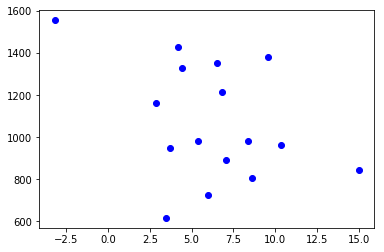

In [9]:
plt.plot(summary_result['mean'], summary_result['count'], 'bo')

In [1]:
# Snowfall amount doesn't play a role?
# I need to look at how snowfall amounts are calculated

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("final_snowfall_and_tows.csv")

In [8]:
tows_df = df.groupby(['emergency'])['emergency'].agg('count')
snow_df = df.groupby(['emergency'])['Snowfall'].agg('mean')
date_df = df.groupby(['emergency'])['date_declared'].agg('min')

In [20]:
tows_df.index.tolist()

['Armatage',
 'Dana',
 'Diamond Lake',
 'Ferry',
 'Grant',
 'Howe',
 'Jane',
 'Olive',
 'Pembina',
 'Polk',
 'Quincy',
 'Upton',
 'Westminster',
 'Xerxes',
 'Yale',
 'Yardville']

In [21]:
tows_df.tolist()

[948,
 1354,
 982,
 1328,
 1556,
 844,
 1430,
 1161,
 962,
 1380,
 617,
 805,
 980,
 1215,
 894,
 728]

In [22]:
tows_df

emergency
Armatage         948
Dana            1354
Diamond Lake     982
Ferry           1328
Grant           1556
Howe             844
Jane            1430
Olive           1161
Pembina          962
Polk            1380
Quincy           617
Upton            805
Westminster      980
Xerxes          1215
Yale             894
Yardville        728
Name: emergency, dtype: int64